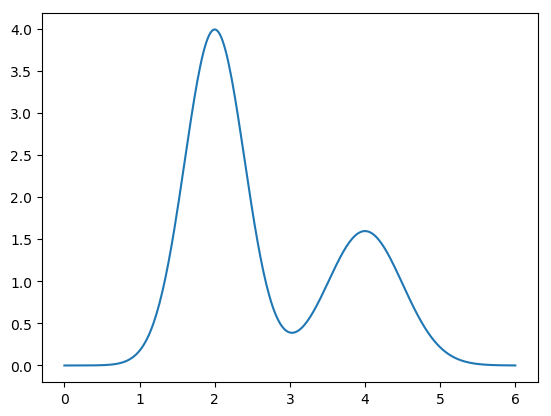

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x19b1f30f0>

In [1]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
kernel_name = "triangular"

function kernel(x::Float64, y::Float64)
    return getOpticsKernels(kernel_name)(x, y)
end

kernel (generic function with 1 method)

Any[

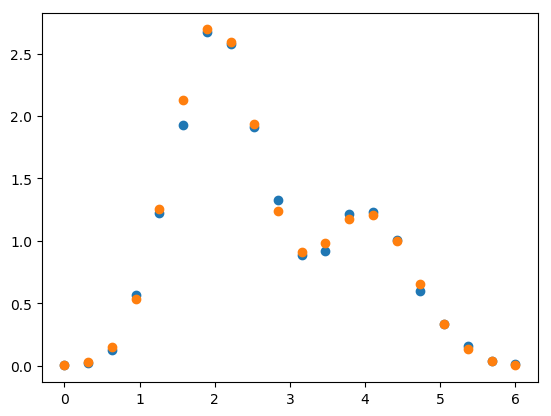

-0.000512733, -0.00886796, -0.0247578, 0.0298135, -0.0361807, -0.20001, -0.019313, -0.0160921, -0.0270347, 0.0943749, -0.0205662, -0.0615944, 0.0414499, 0.0289377, 0.0142734, -0.052217, -0.00294157, 0.0228415, 0.00332766, 0.0044155]


In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=20))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f, "o")
plot(y, ftrue, "o")
println(noise)

┌ Info: Cubic spline basis is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:238


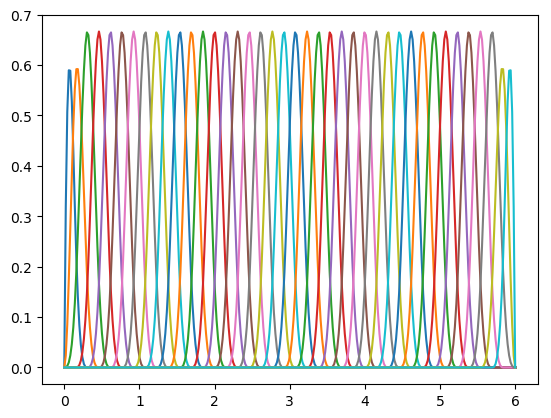

40


In [4]:
knots = collect(range(a, b, length=40))
basis = CubicSplineBasis(knots, ("dirichlet", "dirichlet"))
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
println(length(basis))

40

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:246
┌ Info: Omega caclulated successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:267


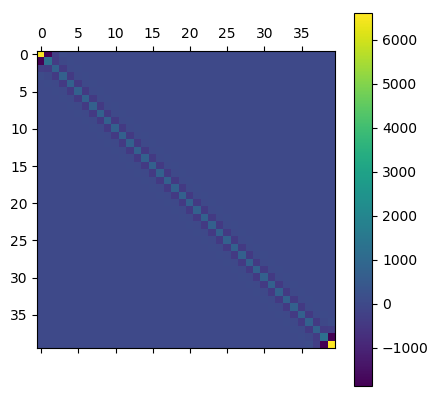

PyObject <matplotlib.colorbar.Colorbar object at 0x19b3f5a90>

In [5]:
print(length(basis))
my_omega = omega(basis, 2)
# for i = 1:size(my_omega)[1]
#     for j = 1:size(my_omega)[1]
#         my_omega[i, j] = abs(my_omega[i, j])
#     end
# end
matshow(my_omega)
colorbar()

In [6]:
model = GaussErrorUnfolder(basis, [omega(basis, 2)])
println()

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:86
┌ Info: GaussErrorUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:261


In [7]:
phi_reconstruct = solve(model, kernel, f, sig, y)

┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:295
┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:48
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:59
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:323
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:117
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:145
┌ Info: Starting solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:156
┌ Info: Starting find_optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:164
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:186


Iter     Function value   Gradient norm 
     0    -2.704620e+02     8.314403e+00
     1    -2.805593e+02     3.611345e+00
     2    -2.826780e+02     5.830154e-02
     3    -2.826785e+02     1.398311e-05
     4    -2.826785e+02     5.714172e-08
     5    -2.826785e+02     1.474625e-08
     6    -2.826785e+02     1.474625e-08
     7    -2.826785e+02     5.529844e-09


┌ Info: Optimized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:202
┌ Info: Ending solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:217


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.00475357 0.0091578 … 4.18255e-6 1.39119e-6; 0.0091578 0.030046…
  "alphas" => [0.0783701]
  "coeff"  => [-0.0214591, -0.0650644, -0.126049, -0.157171, -0.122939, 0.01009…

In [8]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["errors"])
println()

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:69


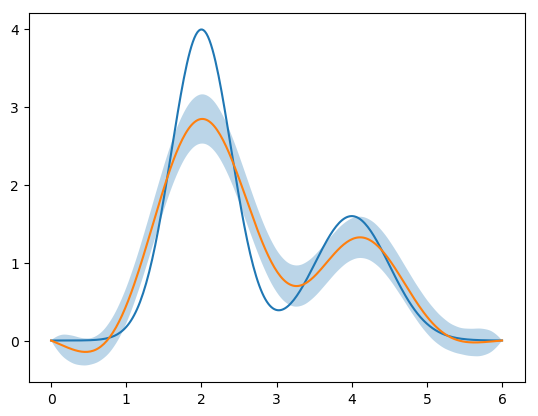

PyObject <matplotlib.collections.PolyCollection object at 0x19b4e03c8>

In [9]:
using PyPlot

plot(x, phi.(x))
# title(kernel_name + "kernel")
phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

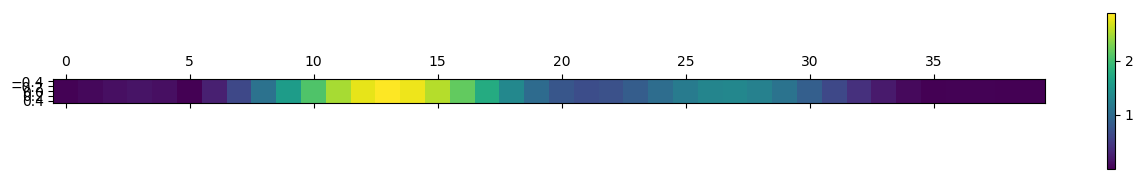

PyObject <matplotlib.colorbar.Colorbar object at 0x188dac320>

In [10]:
matshow(reshape(map(x->abs(x), phi_reconstruct["coeff"]), (1, length(basis))))
colorbar()